In [37]:
import json
import os
from typing import Dict, Any, List, Tuple
# from scipy.spatial.distance import euclidean
import numpy as np
import csv

def pcb_range(border: List[Dict[str, Any]]) -> Tuple[float, float, float, float]:
    if len(border) == 0:
        print("This PCB is not defined with border!")
    xs, ys = [], []
    for line in border:
        if line["type"] == "polyline":
            xs += [line["vertices"][0][0], line["vertices"][1][0]]
            ys += [line["vertices"][0][1], line["vertices"][1][1]]
        # elif line["type"] == "arc":
        #     radius = euclidean(line["start"], line["center"])
        #     xs += [line["center"][0] - radius, line["center"][0] + radius]
        #     ys += [line["center"][1] - radius, line["center"][1] + radius]
        elif line["type"] == "arc":
            center = (np.array(line["vertices"][0]) + np.array(line["vertices"][1])) / 2
            xs += [center[0] - line["radius"], center[0] + line["radius"]]
            ys += [center[1] - line["radius"], center[1] + line["radius"]]
        elif line["type"] == "circle":
            xs += [line["vertices"][1][0] - line["radius"], line["vertices"][1][0] + line["radius"]]
            ys += [line["vertices"][1][1] - line["radius"], line["vertices"][1][1] + line["radius"]]
    
    return min(xs), max(xs), min(ys), max(ys)

def load_json(pcb_file_path: str) -> Dict[str, Any]:
    with open(pcb_file_path) as jf:
        pcb_dict = json.load(jf)
    return pcb_dict

def get_pad_num(pcb_dict):
    n_pad = 0
    for net_idx, net in enumerate(pcb_dict["nets"]):
        if int(net_idx) != -1:
            n_pad += len(net)
    return n_pad

data_folder = "./PCBs/" 
pcb_names = sorted(os.listdir(data_folder))
# print(len(pcb_names))

header = ['Name', 'Width', 'Height', 'Area', '#Layers', '#Nets', '#Pads', 'Net density', 'Pad density', '#DPs']
pad_num = []
layer_num = []
net_num = []
pcb_ranges = []
data = []
dp = []
for pcb_name in pcb_names:
    try:
        raw_pcb_file = os.path.join(data_folder + pcb_name, "raw.kicad_pcb")
        json_pcb_file = os.path.join(data_folder + pcb_name, "final.json")
        if os.path.exists(json_pcb_file):
            # raw_pcb = PCB(raw_pcb_file
            pcb_dict = load_json(json_pcb_file)
            n_nets = len(pcb_dict["nets"])
            n_pads = get_pad_num(pcb_dict)
            n_layers = len(pcb_dict["layers"])
            n_dps = len(pcb_dict["differential_pairs"])
            pcb_size = pcb_range(pcb_dict["border"])
            width = pcb_size[1] - pcb_size[0]
            height = pcb_size[3] - pcb_size[2]
            pad_num.append(n_pads)
            layer_num.append(n_layers)
            net_num.append(n_nets)
            dp.append(n_dps)
            pcb_ranges.append((pcb_size[1] - pcb_size[0], pcb_size[3] - pcb_size[2]))
            data.append([pcb_name, width, height, width * height, n_layers, n_nets, n_pads, n_nets / (width * height *  n_layers), n_pads / (width * height * n_layers), n_dps])
    except:
        print(pcb_name)
        # print(f"layer: {n_layers}, nets: {n_nets}, pads: {n_pads}, range: {(pcb_size[1] - pcb_size[0], pcb_size[3] - pcb_size[2])}")

with open('statistics.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    # write the data
    writer.writerow(header)
    writer.writerows(data)

In [2]:
print(len(dp))
non_zero_dp = [i for i in dp if i != 0]
print(len(non_zero_dp), non_zero_dp)

224
32 [1, 1, 1, 1, 2, 2, 1, 4, 3, 1, 2, 3, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 3, 2, 13, 6, 1, 1, 4, 1, 1]


In [20]:
a = "1sfhdf"
b = a.replace("/", "")

In [38]:
# extract information of power/voltage

from Scripts.Data_extraction.extract_kicad import PCB
import os
import re
import json
from collections import defaultdict

def check_string(input_string):
    input_string = input_string.replace("/", "")
    pattern = r'^[0-9vV+.]+$'
    fixed_names = ["VCC", "VIN", "VDD", "VBB", "vcc", "vdd"]
    if re.match(pattern, input_string):
        return True
    if input_string in fixed_names:
        return True

    return False

pcb_power_nets = defaultdict(list)
data_folder = "./PCBs/" 
pcb_names = sorted(os.listdir(data_folder))
for pcb_name in pcb_names:
        raw_pcb_file = os.path.join(data_folder + pcb_name, "processed.kicad_pcb")
        json_pcb_file = os.path.join(data_folder + pcb_name, "final.json")
        count = 0
        if os.path.exists(json_pcb_file):
            kicad_pcb = PCB(raw_pcb_file)
            for i in range(len(kicad_pcb.pcb.net)):
                # print(kicad_pcb.pcb.net[i][1])
                if check_string(str(kicad_pcb.pcb.net[i][1])):
                    count += 1
                    pcb_power_nets[pcb_name].append(kicad_pcb.pcb.net[i][1])
        if count == 0:
            print(pcb_name)

with open(f'power.json', 'w') as fd:
    s = json.dumps(pcb_power_nets,indent=2)
    fd.write(s)



kitspace_120-channel-test-board
kitspace_BalthazarKeyboard3-keycaps
kitspace_Brk40p
kitspace_CA3306E
kitspace_LED%20Zappelin
kitspace_OpenSpritzer_1.3
kitspace_Potentiometer_mount_16LED
kitspace_Potentiometer_mount_24LED
kitspace_Potentiometer_mount_4LED
kitspace_Potentiometer_mount_8LED
kitspace_T32_ref
kitspace_flypi
kitspace_ideal_diode
kitspace_pmt_combiner
kitspace_power_supply
kitspace_push-on-hold-off
kitspace_sop8breakout
kitspace_ss_relay
kitspace_trans_switch_volt_amp
kitspace_tt_nano_HAT_b1
kitspace_tt_nano_HAT_b2
master_metadata.json
retroreflectors_CONGFLOCK
retroreflectors_FLAMENCOFLOCK
retroreflectors_RUMBAFLOCK
retroreflectors_SALSAFLOCK
retroreflectors_TANGOFLOCK


In [2]:
# extract components

from Scripts.Data_extraction.extract_kicad import PCB
import os
import json
from collections import defaultdict

pcb_components = dict()
data_folder = "./PCBs/" 
pcb_names = sorted(os.listdir(data_folder))
for pcb_name in pcb_names:
        raw_pcb_file = os.path.join(data_folder + pcb_name, "processed.kicad_pcb")
        json_pcb_file = os.path.join(data_folder + pcb_name, "final.json")
        # count = 0
        if os.path.exists(json_pcb_file):
            kicad_pcb = PCB(raw_pcb_file)
            # print(kicad_pcb.pcb.module)
            pcb_components[pcb_name] = len(kicad_pcb.pcb.module)
        # if count == 0:
            # print(pcb_name)

# with open(f'power.json', 'w') as fd:
#     s = json.dumps(pcb_power_nets,indent=2)
#     fd.write(s)
print(pcb_components)

{'1Bitsy_1bitsy': 108, 'JavierIH_kameshield': 11, 'LibreSolar_MPPT_charger_20A': 149, 'Ttl_wlan_radar': 128, 'bishboria_ErgoDox': 64, 'bobc_LCD-panel-adapter-lvc': 13, 'bobc_MS-F100': 33, 'bobc_control_panel': 35, 'bobc_led_clock': 65, 'bobc_matrix_clock': 36, 'bobc_mbeduinopresso': 37, 'cnlohr_wiflier': 57, 'cnlohr_wiflier_B': 61, 'devttys0_IRis': 30, 'hamityanik_ULP-Weather-Logger': 94, 'hwstar_ac-power-monitor': 62, 'jadonk_PocketBone': 65, 'kitspace_120-channel-pogo-pin-board': 17, 'kitspace_120-channel-test-board': 258, 'kitspace_12V5A_breakout': 18, 'kitspace_12_24_boost_converter': 22, 'kitspace_40-channel-hv-switching-board': 204, 'kitspace_4_switch_array': 22, 'kitspace_8_switch_array': 36, 'kitspace_Arduino_uno_sheild': 16, 'kitspace_BQ25570_Harvester': 20, 'kitspace_BalthazarKeyboard3-keycaps': 199, 'kitspace_BalthazarPSU3': 84, 'kitspace_Brk40p': 5, 'kitspace_CA3306E': 10, 'kitspace_CH330': 9, 'kitspace_CO2': 31, 'kitspace_ChaosLooper': 32, 'kitspace_CocoMixtape_UGM_Kicad':

[  0.  20.  40.  60.  80. 100. 120. 140. 160. 180. 200. 220.]


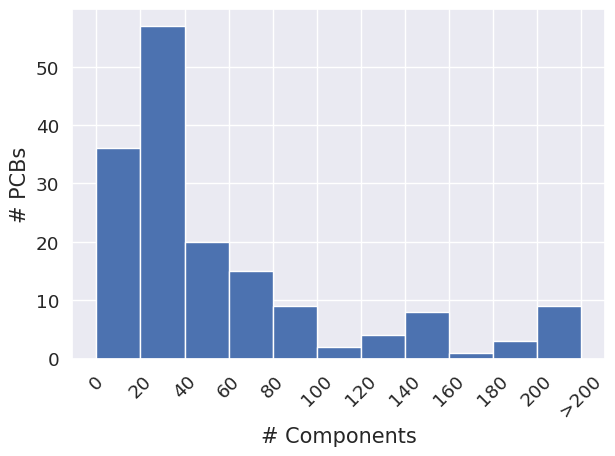

In [14]:
import matplotlib.pyplot as plt

stats_name = "#Components"

stats_data = list(pcb_components.values())
stats_name_range = {"#Components": list(range(0, 210, 20)) + [700]}
name_range = stats_name_range[stats_name]
# print(stats_name_range)
for idx, c in enumerate(stats_data):
    for i in range(len(name_range)-1):
        if name_range[i] <= c < name_range[i+1]:
            stats_data[idx] = int( name_range[i] + (name_range[1] - name_range[0]) / 2 )

# fig, ax = plt.subplots()
# ax.bar([str(nr) for nr in name_range[1:]], range_count, label=name_range[1:], color="steelblue")

# ax.set_xlabel('# Nets', fontsize=15)
# ax.set_ylabel('# PCBs', fontsize=15)

# # fig.savefig("dp_dist.pdf")

num_bins = name_range[:-1] + [name_range[-2] + name_range[1] - name_range[0]]

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(stats_data, num_bins)
print(bins)

labels = [str(nr) for nr in num_bins]
labels[-1] = f">{labels[-2]}"
plt.xticks(num_bins, labels, rotation=45)

ax.set_xlabel('# Components', fontsize=15)
ax.set_ylabel('# PCBs', fontsize=15)

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
# plt.grid()
fig.savefig("components_dist.pdf", bbox_inches='tight')
plt.show()

In [4]:
print(max(pcb_components.values()), min(pcb_components.values()))

670 3


+0.6V


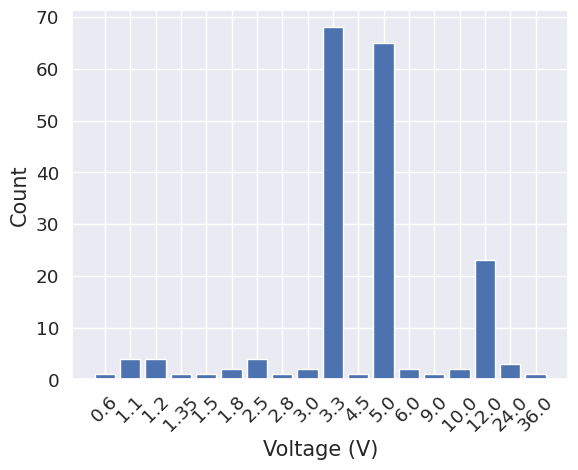

In [10]:
import seaborn as sns
import pandas as pd
import json
from collections import defaultdict


def load_json(pcb_file_path: str):
    with open(pcb_file_path) as jf:
        pcb_dict = json.load(jf)
    return pcb_dict

pcb_power_nets = load_json("power.json")
voltage_count = defaultdict(int)
pcb_voltage = []
for name in pcb_power_nets:
    for v in pcb_power_nets[name]:
        tmp = v
        value = -1
        v = str(v)
        if 'V' in v:
            v = v.replace("+", "")
            v = v.replace("/", "")
            if v[-1].isdigit():
                v = v.replace("V", ".")
                if v[0] != ".":
                    value = float(v)
            elif v[-1] == "V":
                try:
                    value = float(v[:-1])
                except:
                    a = 0
        if value < 1 and value != -1:
            print(tmp)
        if value != -1:
            voltage_count[value] += 1
            pcb_voltage.append(value)


import matplotlib.pyplot as plt

names = list(voltage_count.keys())
values = list(voltage_count.values())


values = [x for _,x in sorted(zip(names,values))]
names.sort()
# names = [str(n) + "V" for n in names]

# pd_data = pd.DataFrame({"Voltage (V)": names, "Count":values})
# # sns.set(font_scale = 1.2)
# g = sns.barplot(pd_data, x="Voltage (V)", y="Count", color='steelblue')
# g.set_xticklabels(labels=names, rotation=30)
# print(pd_data)
# # Show the plot
# plt.show()


import matplotlib.pyplot as plt

fig, ax = plt.subplots()

names_str = [str(n) for n in names]
ax.bar(names_str, values, label=names_str)

ax.set_xlabel("Voltage (V)", fontsize=15)
ax.set_ylabel('Count', fontsize=15)
plt.xticks(rotation=45)

fig.savefig("voltage_dist.pdf", bbox_inches='tight')
plt.show()

# plt.bar(range(len(voltage_count)), values, tick_label=names)
# plt.xticks(rotation=30)
# plt.xlabel('Voltage (V)')
# plt.ylabel('Count')
# plt.show()

# print(voltage_count)

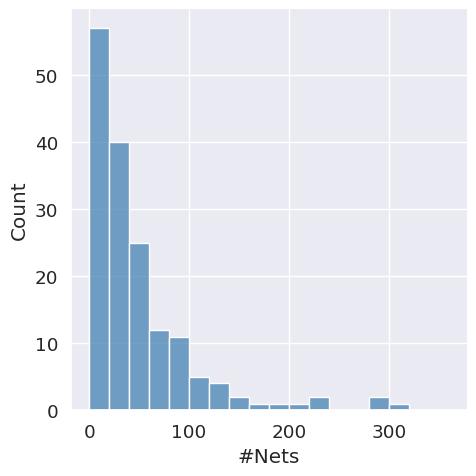

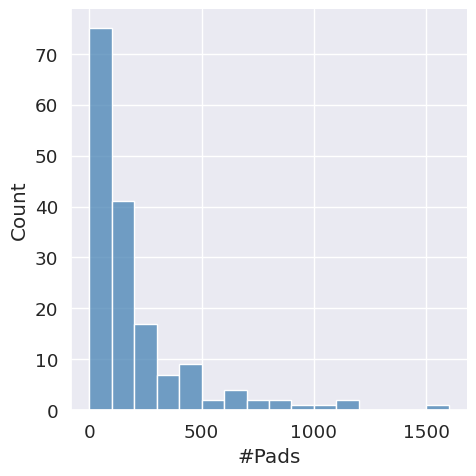

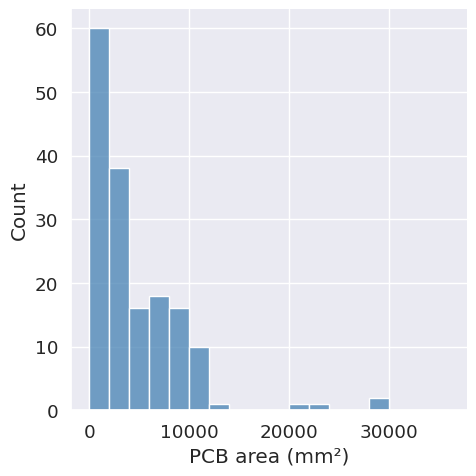

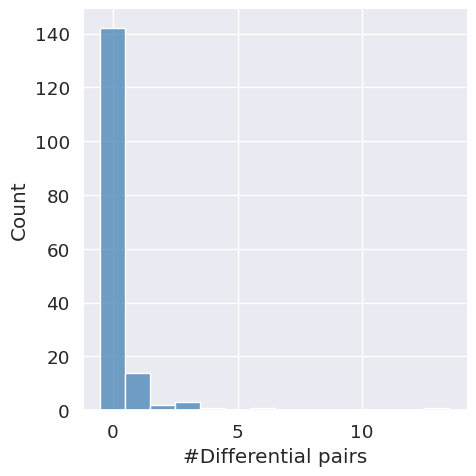

In [12]:
import seaborn as sns
import pandas as pd

sns.set(font_scale = 1.2)
data = pd.read_csv("statistics.csv")
# f_layer = sns.displot(data, x="#Layers", discrete=True, color="steelblue")
# f_layer.savefig("layer_dist.pdf")

f_nets = sns.displot(data, x="#Nets", binwidth=20, binrange=(0, 350), color="steelblue")
# # f_nets.set(xlabel='Nets desity (#/mm\u00b2)')
f_nets.savefig("nets_dist.pdf")


import matplotlib.pyplot as plt

# num_bins = 30

# fig, ax = plt.subplots()

# # the histogram of the data
# n, bins, patches = ax.hist(data["#Nets"], num_bins)

# print(bins)
# ax.set_xlabel('# Nets', fontsize=15)
# ax.set_ylabel('# PCBs', fontsize=15)

# # Tweak spacing to prevent clipping of ylabel
# fig.tight_layout()
# # plt.grid()
# fig.savefig("nets_dist.pdf")
# plt.show()


# n, bins, patches = ax.hist(data["#Pads"], num_bins)

# print(bins)
# ax.set_xlabel('# Pads', fontsize=15)
# ax.set_ylabel('# PCBs', fontsize=15)

# # Tweak spacing to prevent clipping of ylabel
# fig.tight_layout()
# # plt.grid()
# fig.savefig("pads_dist.pdf")
# plt.show()

# n, bins, patches = ax.hist(data["Area"], num_bins)

# print(bins)
# ax.set_xlabel('# PCB area (mm\u00b2)', fontsize=15)
# ax.set_ylabel('# PCBs', fontsize=15)

# # Tweak spacing to prevent clipping of ylabel
# fig.tight_layout()
# # plt.grid()
# fig.savefig("area_dist.pdf")
# plt.show()

# n, bins, patches = ax.hist(data["#DPs"])

# print(bins)
# ax.set_xlabel('# PCB area (mm\u00b2)', fontsize=15)
# ax.set_ylabel('# PCBs', fontsize=15)

# # Tweak spacing to prevent clipping of ylabel
# fig.tight_layout()
# # plt.grid()
# fig.savefig("area_dist.pdf")
# plt.show()

f_pads = sns.displot(data, x="#Pads", binwidth=100, binrange=(0, 1510), color="steelblue")
f_pads.savefig("pads_dist.pdf")

f_area = sns.displot(data, x="Area", binwidth=2000, binrange=(0, 35000), color="steelblue")
f_area.set(xlabel='PCB area (mm\u00b2)')
f_area.savefig("area_dist.pdf")

f_dp = sns.displot(data, x="#DPs", binwidth=1, binrange=(0, 13), discrete=True, color="steelblue")
f_dp.set(xlabel='#Differential pairs')
f_dp.savefig("dp.pdf")

# new_dp = data["#DPs"].value_counts()
# new_dp = pd.DataFrame({"# Differential pairs": list(new_dp.keys()), "Count":[new_dp[i] for i in new_dp.keys()]})
# f_dp_bar = sns.barplot(new_dp, x="# Differential pairs", y="Count", color="steelblue")
# print(new_dp)
# fig = f_dp_bar.get_figure()
# fig.savefig("dp_bar.pdf")

# sns.displot(data, x="Net density")
# sns.displot(data, x="Pad density")

[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110.]


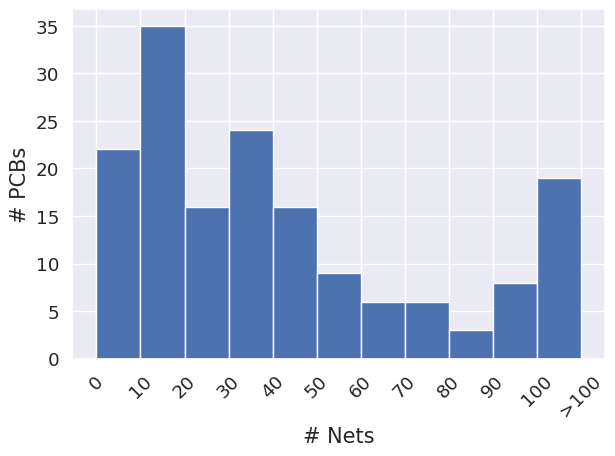

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

data = pd.read_csv("statistics.csv")
stats_name = "#Nets"

stats_data = list(data[stats_name])
stats_name_range = {"#Nets": list(range(0, 110, 10))+[400], "#Pads": list(range(0, 510, 50)) + [2000], "Area": list(range(0, 11000, 1000)) + [40000]}
name_range = stats_name_range[stats_name]
# print(stats_name_range)
for idx, c in enumerate(stats_data):
    for i in range(len(name_range)-1):
        if name_range[i] <= c < name_range[i+1]:
            stats_data[idx] = int( name_range[i] + (name_range[1] - name_range[0]) / 2 )

# fig, ax = plt.subplots()
# ax.bar([str(nr) for nr in name_range[1:]], range_count, label=name_range[1:], color="steelblue")

# ax.set_xlabel('# Nets', fontsize=15)
# ax.set_ylabel('# PCBs', fontsize=15)

# # fig.savefig("dp_dist.pdf")

num_bins = name_range[:-1] + [name_range[-2] + name_range[1] - name_range[0]]

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(stats_data, num_bins)
print(bins)

labels = [str(nr) for nr in num_bins]
labels[-1] = f">{labels[-2]}"
plt.xticks(num_bins, labels, rotation=45)

ax.set_xlabel('# Nets', fontsize=15)
ax.set_ylabel('# PCBs', fontsize=15)

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
# plt.grid()
fig.savefig("nets_dist.pdf")
plt.show()

['1', '2', '3', '4', '6', '13'] [14, 2, 3, 1, 1, 1]


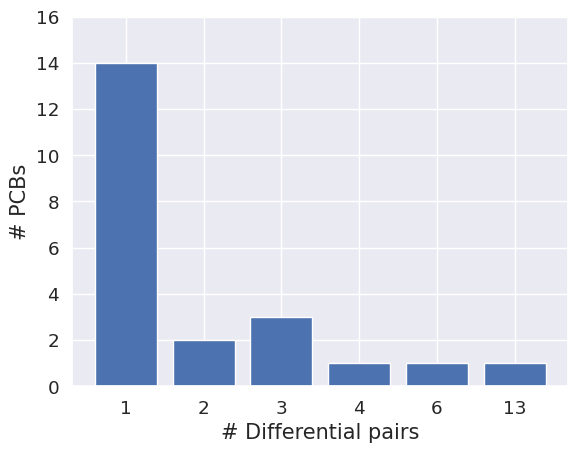

In [13]:
new_dp = data["#DPs"].value_counts()
new_dp = {"# Differential pairs": list(new_dp.keys()), "Count":[new_dp[i] for i in new_dp.keys()]}


import matplotlib.pyplot as plt

fig, ax = plt.subplots()

dp_num = [str(n) for n in sorted(new_dp["# Differential pairs"])][1:]
counts = [x for _, x in sorted(zip(new_dp["# Differential pairs"], new_dp["Count"]), key=lambda pair: pair[0])][1:]
print(dp_num, counts)
ax.bar(dp_num, counts, label=dp_num)

plt.yticks(range(0, 17, 2), range(0, 17, 2))
ax.set_xlabel('# Differential pairs', fontsize=15)
ax.set_ylabel('# PCBs', fontsize=15)

fig.savefig("dp_dist.pdf", bbox_inches='tight')
plt.show()

In [47]:
164-14-2-3-3

142